In [17]:
from manifold_learning import IMD
from FastCCM import CCM
import numpy as np
from pydmd import DMD, BOPDMD, HAVOK
from manifold_learning.utils import utils
from sklearn.decomposition import PCA
from pydmd.preprocessing import zero_mean_preprocessing
from pydmd.plotter import plot_summary
from manifold_learning.data.data_loader import load_csv_dataset,get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import imageio
import os
import tempfile
import importlib
importlib.reload(IMD)
importlib.reload(CCM)
importlib.reload(utils)

<module 'manifold_learning.utils.utils' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/utils/utils.py'>

In [33]:
X = get_truncated_lorenz_rand(400,n_steps=20000)

In [3]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

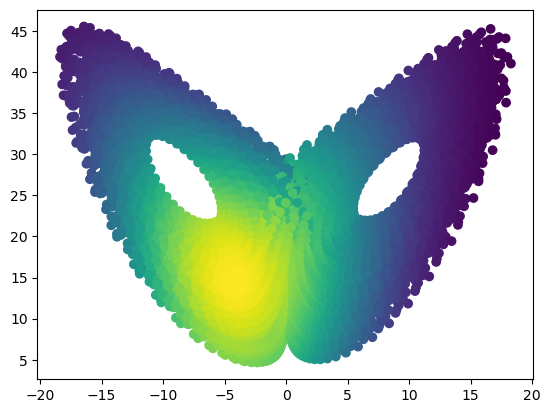

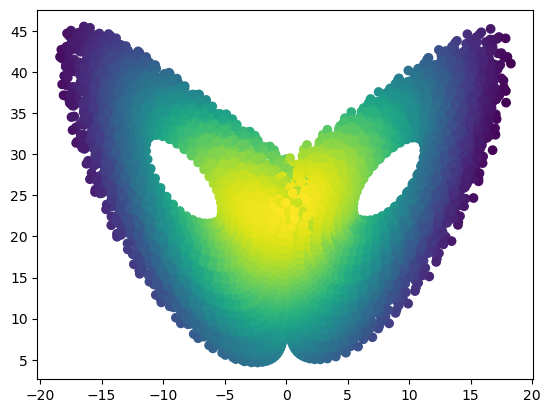

In [4]:
plt.scatter(X[:,0],X[:,2],c=gaussian_kernel(X,X[1100],sigma=15))
plt.show()
plt.scatter(X[:,0],X[:,2],c=gaussian_kernel(X,X[1800],sigma=15))
plt.show()

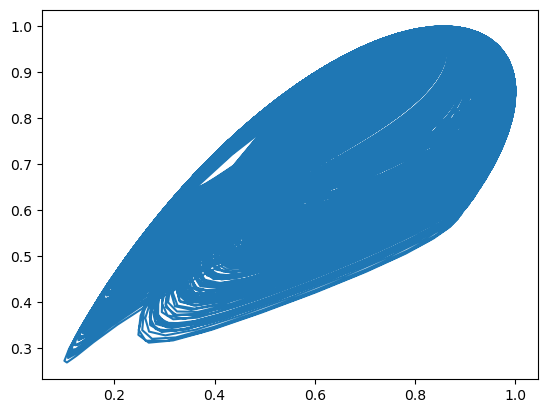

In [5]:
plt.plot(gaussian_kernel(X,X[1100],sigma=20),gaussian_kernel(X,X[1800],sigma=20))

In [6]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),8), np.linspace(X[:,2].min(),X[:,2].max(),8))).reshape(2,-1).T

In [8]:
observables = np.array([gaussian_kernel(X[:,[0,2]],e,sigma=5) for e in exp_kernel_grid]).T

In [34]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),40), np.linspace(X[:,2].min(),X[:,2].max(),40))).reshape(2,-1).T
observables = np.array([gaussian_kernel(X[:,[0,2]],e,sigma=5) for e in exp_kernel_grid]).T
with tempfile.TemporaryDirectory() as tempdir:
    filenames = []
    for i, frame in enumerate(observables.reshape(-1,40,40)[:2000]):
        plt.imshow(frame, cmap='viridis')
        plt.axis('off')
        filename = os.path.join(tempdir, f'frame_{i}.png')
        plt.savefig(filename)
        filenames.append(filename)
        plt.close()

    with imageio.get_writer('output.mp4', fps=30) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

/tmp/ipykernel_474863/4228224139.py:13: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [7]:
X_ = [get_truncated_lorenz_rand(800,n_steps=40000)[:,[0,2]] for i in range(5)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=15) for e in exp_kernel_grid]) for x in X_]).T


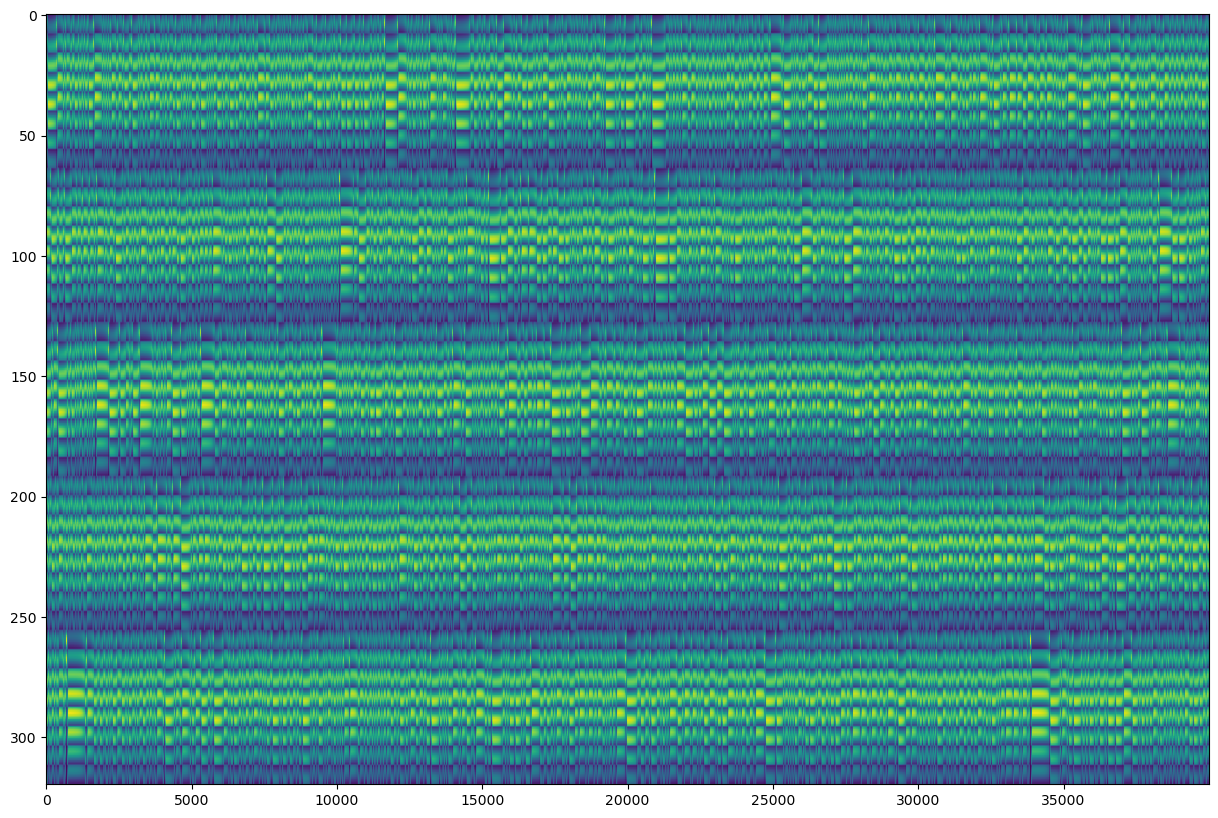

In [8]:
plt.figure(figsize=(15,10))
plt.imshow(observables.T,aspect="auto")

In [216]:
observables = utils.get_td_embedding_np(observables,3,5).reshape(-1,3*observables.shape[1])


In [9]:
observables = StandardScaler().fit_transform(observables)

In [592]:
trainer = IMD.IMD_nD(observables.shape[1], embed_dim=3, n_components=10,subtract_corr=True, device="cuda")

In [625]:
import torch
from manifold_learning.utils import utils
trainer.model.to("cpu")(torch.Tensor(observables,device="cpu")).shape

torch.Size([40000, 3, 10])

In [553]:
trainer.fit(observables, sample_len=400, library_len=1200, 
            exclusion_rad=20, nbrs_num=30, tp=20, 
            epochs=2000, num_batches=32,optimizer="Adagrad", learning_rate=0.002,tp_policy="fixed")


Epoch 1/2000, Loss: 0.7445
Epoch 2/2000, Loss: 0.7810
Epoch 3/2000, Loss: 0.7542
Epoch 4/2000, Loss: 0.6845
Epoch 5/2000, Loss: 0.6372
Epoch 6/2000, Loss: 0.6142
Epoch 7/2000, Loss: 0.5981
Epoch 8/2000, Loss: 0.5798
Epoch 9/2000, Loss: 0.5654
Epoch 10/2000, Loss: 0.5513
Epoch 11/2000, Loss: 0.5422
Epoch 12/2000, Loss: 0.5327
Epoch 13/2000, Loss: 0.5221
Epoch 14/2000, Loss: 0.5175
Epoch 15/2000, Loss: 0.5090
Epoch 16/2000, Loss: 0.5018
Epoch 17/2000, Loss: 0.4979
Epoch 18/2000, Loss: 0.4890
Epoch 19/2000, Loss: 0.4886
Epoch 20/2000, Loss: 0.4848
Epoch 21/2000, Loss: 0.4752
Epoch 22/2000, Loss: 0.4783
Epoch 23/2000, Loss: 0.4746
Epoch 24/2000, Loss: 0.4760
Epoch 25/2000, Loss: 0.4686
Epoch 26/2000, Loss: 0.4687
Epoch 27/2000, Loss: 0.4653
Epoch 28/2000, Loss: 0.4636
Epoch 29/2000, Loss: 0.4676
Epoch 30/2000, Loss: 0.4694
Epoch 31/2000, Loss: 0.4684
Epoch 32/2000, Loss: 0.4676
Epoch 33/2000, Loss: 0.4652
Epoch 34/2000, Loss: 0.4665
Epoch 35/2000, Loss: 0.4633
Epoch 36/2000, Loss: 0.4642
E

KeyboardInterrupt: 

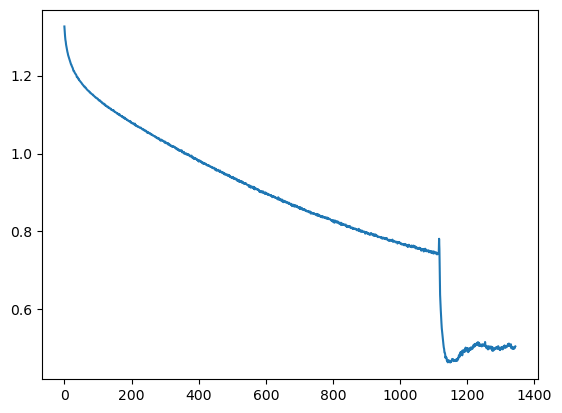

In [554]:
plt.plot(trainer.get_loss_history()[:])


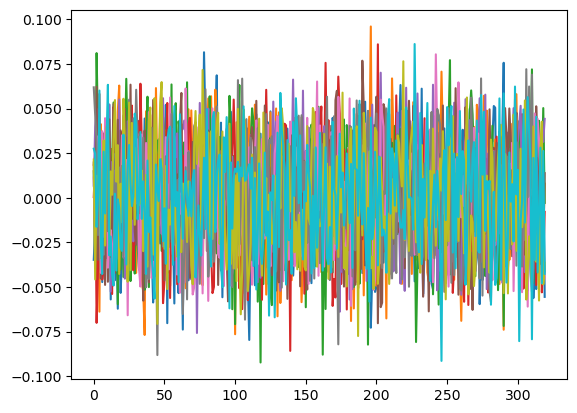

In [555]:
plt.plot(trainer.model.get_weights()[:,0])

In [556]:
plt.matshow(trainer.model.get_weights()[:,0,9].reshape(32,16))
plt.colorbar()

ValueError: cannot reshape array of size 320 into shape (32,16)

(array([1.000e+00, 1.000e+00, 3.000e+00, 1.200e+01, 1.200e+01, 1.700e+01,
        2.500e+01, 4.400e+01, 6.400e+01, 1.000e+02, 1.650e+02, 2.590e+02,
        4.310e+02, 6.430e+02, 8.730e+02, 1.029e+03, 1.218e+03, 1.264e+03,
        1.253e+03, 1.269e+03, 1.259e+03, 1.344e+03, 1.329e+03, 1.285e+03,
        1.307e+03, 1.344e+03, 1.258e+03, 1.344e+03, 1.344e+03, 1.266e+03,
        1.290e+03, 1.270e+03, 1.294e+03, 1.235e+03, 1.189e+03, 1.033e+03,
        9.170e+02, 6.940e+02, 4.860e+02, 3.290e+02, 2.030e+02, 1.070e+02,
        7.100e+01, 3.700e+01, 2.400e+01, 2.000e+01, 1.200e+01, 1.100e+01,
        9.000e+00, 6.000e+00]),
 array([-0.10821398, -0.10399448, -0.09977498, -0.09555548, -0.09133599,
        -0.08711649, -0.08289699, -0.0786775 , -0.074458  , -0.0702385 ,
        -0.06601901, -0.06179951, -0.05758001, -0.05336051, -0.04914102,
        -0.04492152, -0.04070202, -0.03648252, -0.03226303, -0.02804353,
        -0.02382403, -0.01960454, -0.01538504, -0.01116554, -0.00694604,
        -0.

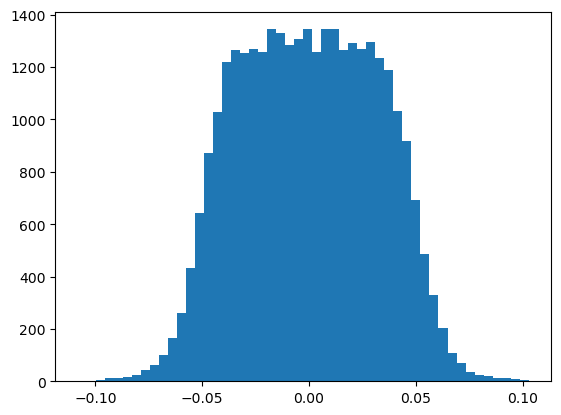

In [557]:
plt.hist(trainer.model.get_weights().flatten(),bins=50)

In [22]:

unmixed = trainer.predict(observables)

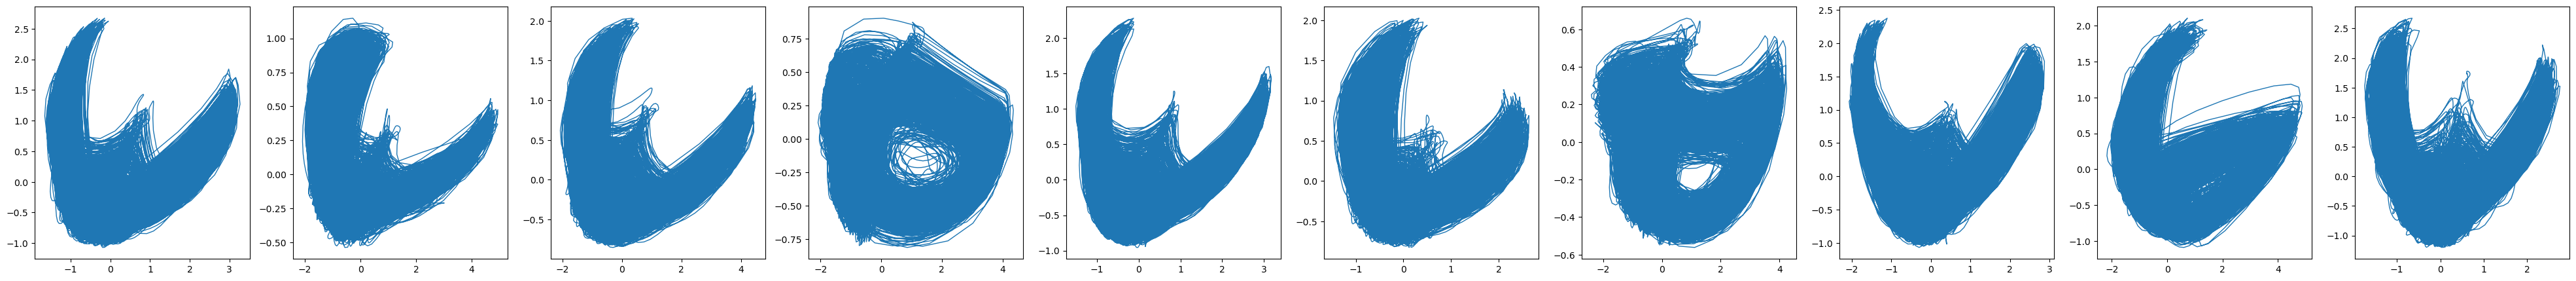

In [559]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

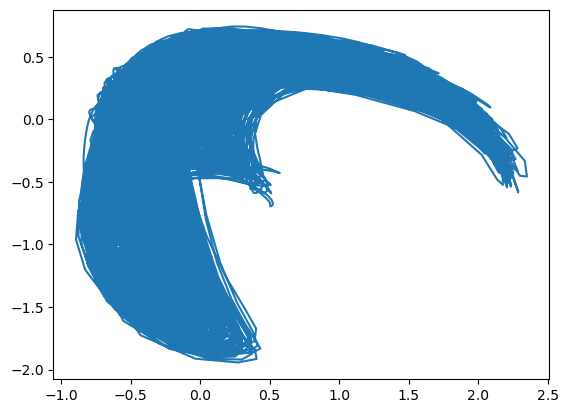

In [560]:
plt.plot(unmixed[:,4,1],unmixed[:,4,2])

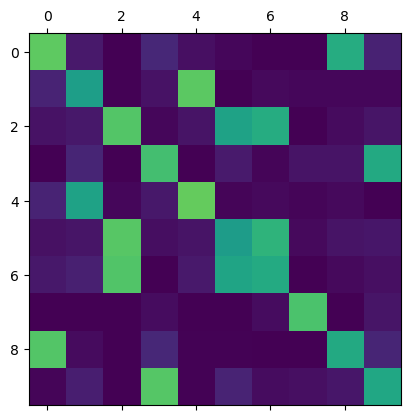

In [561]:
plt.matshow(CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),np.transpose(unmixed,axes=(1,0,2)),1500,400,60,30,30).mean(axis=0),vmin=0,vmax=1)

In [562]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,0,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()

In [564]:
havok = HAVOK(svd_rank=0,delays=1,lag=1,num_chaos=5,)

havok.fit(observables.T,np.arange(observables.shape[0]))

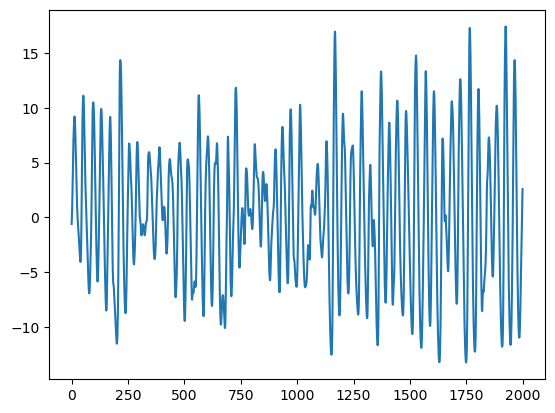

In [584]:
plt.plot((observables @ havok.modes[:,1].real)[:2000])

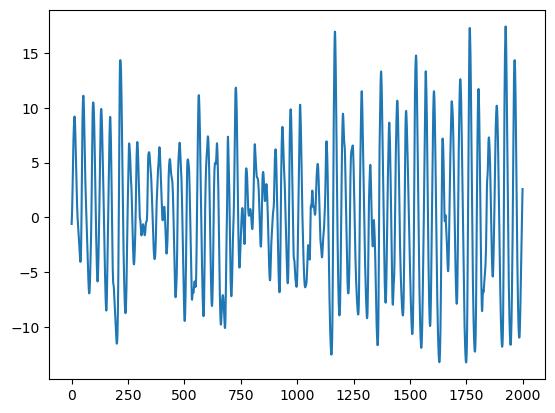

In [585]:
plt.plot(PCA(3).fit_transform(observables)[:2000,1])

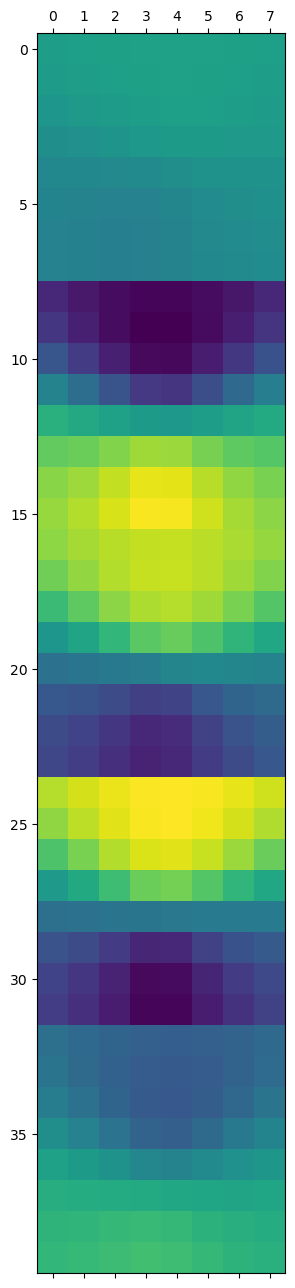

In [576]:
plt.matshow(havok.modes[:,0].reshape(40,8))

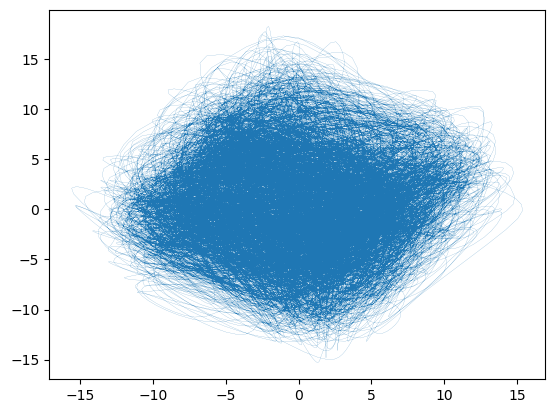

In [572]:
plt.plot((observables @ havok.modes)[:,2],(observables @ havok.modes)[:,1],linewidth=0.1)

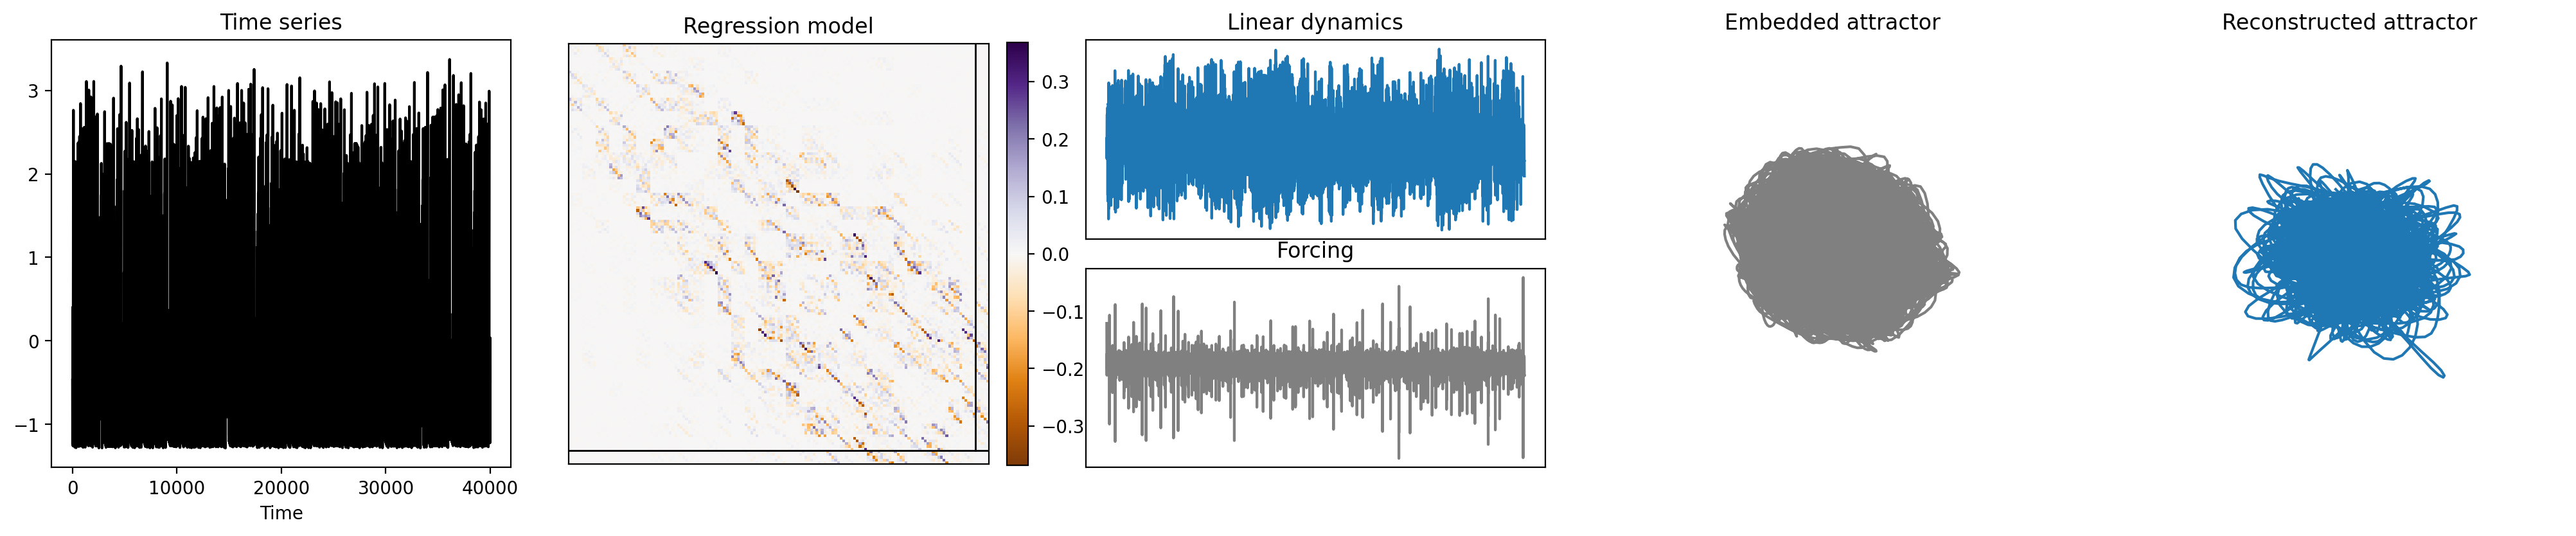

In [575]:
havok.plot_summary()